# Smoke estimates

In [1_data_aquisition_wildfire.ipynb](1_data_aquisition_wildfire.ipynb), we've collected data about wildland fires recorded in the last 60 years in the USA.
In [2_data_aquisition_aqi.ipynb](2_data_aquisition_aqi.ipynb) we collected AQI data from from all the monitoring stations in the San Joaquin county of the state of California. 
In [3_data_cleaning.ipync ](3_data_cleaning.ipynb), we cleaned the AQI data collected and aggregated the per station per day per pollutant AQI data into an yearly aqi estimate at the city of Stockton, CA.

In this notebook, the goal is to come up with a metric to represent smoke estimates in the city using the wildland fire data from last 60 years. We use only the data corresponding to the wildfires which are within 650 miles from our city. Once we gain confidence on our smoke estimate metric is a good representation of the smoke created during wildland fires, we will then proceed to forcast the smoke estimates for the next 25 years.

### Preliminaries
First we start with some imports statements

In [1]:
%%capture
%pip install scipy
%pip install statsmodels
%pip install sklearn
%pip install pyarrow

In [2]:
import polars as pl
import pyarrow
import matplotlib.pyplot as plt
import pandas as pd

We'll load the files generated by the previous notebooks for our analysis. Since we are interested in wildfires within 650 miles from the city, we'll filter out the others.

Since the closest distances are already calculated and stored in the file generated by [1_data_aquisition_wildfire.ipynb](1_data_aquisition_wildfire.ipynb), we do not need additional computation here

In [3]:
wildfires_with_distances = pl.read_csv("generated_files/intermediate/wildfires_with_distances.csv")

# find wildfires within 650 miles from the city of interest
wildfires_in_proximity = (
    wildfires_with_distances
    .filter(
        pl.col("Closest_Distance_Miles") <= 650
    )
) 

wildfires_in_proximity

OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,Listed_Fire_Codes,Listed_Fire_IDs,Listed_Fire_IRWIN_IDs,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Closest_Distance_Miles
i64,i64,str,i64,i64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64
14600,14600,"""Wildfire""",1964,1,"""1 (1), 3 (3)""",65338.877636,26441.705659,"""Comb_National_NIFC_Interagency…","""Wildfire (3), Likely Wildfire …","""COYOTE (4)""","""No code provided (4)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (1…","""Undetermined (4)""",null,null,null,null,0.263753,null,"""No""",112240.801495,2.6442e8,250.77864
14601,14601,"""Wildfire""",1964,1,"""1 (2), 3 (3), 5 (1)""",55960.694158,22646.489455,"""Comb_National_NIFC_Interagency…","""Wildfire (5), Likely Wildfire …","""C. HANLY (5), Hanley (1)""","""No code provided (5), 198 (1)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (1…","""Undetermined (6)""",null,null,null,null,0.224592,null,"""No""",112566.141954,2.2646e8,76.420104
14602,14602,"""Wildfire""",1964,1,"""1 (2), 3 (3)""",19218.105903,7777.29153,"""Comb_National_NIFC_Interagency…","""Wildfire (4), Likely Wildfire …","""COZY DELL (5)""","""No code provided (5)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (1…","""Undetermined (5)""",null,null,null,null,0.138493,null,"""No""",84004.974692,7.7773e7,327.916719
14603,14603,"""Wildfire""",1964,1,"""1 (2), 3 (3)""",18712.494746,7572.677954,"""Comb_National_NIFC_Interagency…","""Wildfire (4), Likely Wildfire …","""HAYFORK HWY. #2 (5)""","""No code provided (5)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""9 - Miscellaneous (1)""","""Undetermined (4), Human (1)""",null,null,null,null,0.39196,null,"""No""",49273.004457,7.5727e7,198.853859
14604,14604,"""Wildfire""",1964,1,"""1 (4), 3 (6)""",16887.001024,6833.926855,"""Comb_National_NIFC_Interagency…","""Wildfire (8), Likely Wildfire …","""MATTOLE (5), ROBERTS COOP. ESC…","""No code provided (10)""","""0 (6)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (2…","""Undetermined (10)""",null,null,null,null,0.392989,null,"""No""",46746.577459,6.8339e7,219.778526
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
135056,135056,"""Prescribed Fire""",2020,8,"""8 (2)""",14.545208,5.886237,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (2)""","""2_PHMA_FIAT_Beulah_East_Bendir…","""No code provided (2)""","""NFPORS6318576 (2)""",null,"""Listed Prescribed Fire End Dat…","""Human (2)""","""Human (2)""",null,null,null,null,0.29925,null,"""No""",1572.196739,58862.370422,453.342716
135057,135057,"""Prescribed Fire""",2020,8,"""8 (3)""",16.412148,6.641761,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (3)""","""WEW CA Broadcast (3)""","""No code provided (3)""","""NFPORS6319933 (3)""",null,"""Listed Prescribed Fire End Dat…","""Human (3)""","""Human (3)""",null,null,null,"""Caution, this Prescribed Fire …",0.177425,null,"""No""",2168.90074,66417.60679,406.63243
135058,135058,"""Prescribed Fire""",2020,8,"""8 (1)""",7.050837,2.853373,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (1)""","""2_PHMA_FIAT_Beulah_East_Bendir…","""No code provided (1)""","""NFPORS6318576 (1)""",null,"""Listed Prescribed Fire End Dat…","""Human (1)""","""Human (1)""",null,null,null,"""Caution, this Prescribed Fire …",0.374368,null,"""No""",978.666221,28533.725602,449.230338


### Smoke estimate calculation

Since there is no predefined formula for calculating smoke estimates, lets explore the available data to check what might be some good features that can be used to estimate smoke.
For this, lets start with some exploration of the data by checking what are columns are available. We'll also look at some fields that seem interesting, to find if they can be used for our smoke estimate calculation

In [4]:
# doing some EDA
print("Available columns")
wildfires_in_proximity.columns

Available columns


['OBJECTID',
 'USGS_Assigned_ID',
 'Assigned_Fire_Type',
 'Fire_Year',
 'Fire_Polygon_Tier',
 'Fire_Attribute_Tiers',
 'GIS_Acres',
 'GIS_Hectares',
 'Source_Datasets',
 'Listed_Fire_Types',
 'Listed_Fire_Names',
 'Listed_Fire_Codes',
 'Listed_Fire_IDs',
 'Listed_Fire_IRWIN_IDs',
 'Listed_Fire_Dates',
 'Listed_Fire_Causes',
 'Listed_Fire_Cause_Class',
 'Listed_Rx_Reported_Acres',
 'Listed_Map_Digitize_Methods',
 'Wildfire_and_Rx_Flag',
 'Overlap_Within_1_or_2_Flag',
 'Circleness_Scale',
 'Circle_Flag',
 'Exclude_From_Summary_Rasters',
 'Shape_Length',
 'Shape_Area',
 'Closest_Distance_Miles']

In [5]:
wildfires_in_proximity.group_by("Assigned_Fire_Type").len()

Assigned_Fire_Type,len
str,u32
"""Likely Wildfire""",1562
"""Prescribed Fire""",13920
"""Wildfire""",36813
"""Unknown - Likely Wildfire""",43
"""Unknown - Likely Prescribed Fi…",124


The field `Assigned_Fire_Type` seems to provide information about which firetype it is. This might be a useful information while calculating smoke estimates, since the type of wildfire gives us some information about the cause/severity. For eg, likely wildfires might not contribute much to the smoke in the region.

In [6]:
wildfires_in_proximity.group_by("Circle_Flag").len() 

Circle_Flag,len
f64,u32
1.0,4826
null,47636


We notice that the column `Circle_Flag` has too many nulls. We can safely ignore this field for smoke estimate calculation

In [7]:
wildfires_in_proximity.filter(pl.col("OBJECTID") != pl.col("USGS_Assigned_ID")) 

OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,Listed_Fire_Codes,Listed_Fire_IDs,Listed_Fire_IRWIN_IDs,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Closest_Distance_Miles
i64,i64,str,i64,i64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64


We see that the two columns `OBJECTID` and `USGS_Assigned_ID` are the same. We can keep one of them to uniquely identify a wildfire, and ignore the other.

In [8]:
print("Min GIS acres burnt")
print(wildfires_in_proximity.select("GIS_Acres").min())

print("Max GIS acres burnt")
print(wildfires_in_proximity.select("GIS_Acres").max())

Min GIS acres burnt
shape: (1, 1)
┌───────────┐
│ GIS_Acres │
│ ---       │
│ f64       │
╞═══════════╡
│ 0.000005  │
└───────────┘
Max GIS acres burnt
shape: (1, 1)
┌───────────┐
│ GIS_Acres │
│ ---       │
│ f64       │
╞═══════════╡
│ 1.0327e6  │
└───────────┘


Using the exploratory data analysis conducted above, we can come up with a few fields that we think uniquely represent all the information about a wildfire that is potentially useful for estimating the smoke from a wildfire

In [9]:
# selecting fields that might be useful to estimate smoke
wildfires_compact_df = (
    wildfires_in_proximity
    .select([
        # 'OBJECTID', # since the value is same as USGS_Assigned_ID
        'USGS_Assigned_ID',
        'Assigned_Fire_Type',
        'Fire_Year',
        # 'Fire_Polygon_Tier',
        # 'Fire_Attribute_Tiers',
        'GIS_Acres',
        # 'GIS_Hectares', # since we are already considering area under the field GIS_Acres
        # 'Source_Datasets', # text values, cannot be used for smoke estimate calculations
        # 'Listed_Fire_Types',
        # 'Listed_Fire_Names',
        # 'Listed_Fire_Codes',
        # 'Listed_Fire_IDs',
        # 'Listed_Fire_IRWIN_IDs',
        # 'Listed_Fire_Dates',
        # 'Listed_Fire_Causes',
        # 'Listed_Fire_Cause_Class',
        # 'Listed_Rx_Reported_Acres',
        # 'Listed_Map_Digitize_Methods',
        # 'Wildfire_and_Rx_Flag',
        # 'Overlap_Within_1_or_2_Flag',
        'Circleness_Scale',
        # 'Circle_Flag', # since majority are nulls, and we already considered Circleness_Scale
        # 'Exclude_From_Summary_Rasters',
        'Shape_Length',
        'Shape_Area',
        'Closest_Distance_Miles'
    ])
)

wildfires_compact_df

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles
i64,str,i64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526
…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338


Since the type of wildland fire gives us some information about the severity of the fire, lets map the values to a factor. We'll use this factor in the smoke estimate calculation. We decided to give lower factor to the known fires, and highest factors to the prescribed fires and wildfires.

We'll then join these factors to the wildfires table to create a new column of the mapped values

In [10]:
# creating a dataframe to map the assigned firetypes to a value

firetypes_df = pl.DataFrame(
    [
        {
            "fire_type": "Unknown - Likely Wildfire",
            "factor": 0.7
        },
        {
            "fire_type": "Likely Wildfire",
            "factor": 0.8
        },
        {
            "fire_type": "Unknown - Likely Prescribed Fire",
            "factor": 0.7
        },
        {
            "fire_type": "Prescribed Fire",
            "factor": 1.0
        },
        {
            "fire_type": "Wildfire",
            "factor": 1.0
        }
    ]
)

firetypes_df

fire_type,factor
str,f64
"""Unknown - Likely Wildfire""",0.7
"""Likely Wildfire""",0.8
"""Unknown - Likely Prescribed Fi…",0.7
"""Prescribed Fire""",1.0
"""Wildfire""",1.0


In [11]:
wildfires_enriched_1 = (
    wildfires_compact_df
    .join(
        firetypes_df,
        left_on = "Assigned_Fire_Type",
        right_on = "fire_type"
    )
    .rename(
        {
            "factor": "fire_type_factor"
        }
    )
)
wildfires_enriched_1

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor
i64,str,i64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0
…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0


We now proceed to add other calculated columns that we think are useful for estimating smokes. Some decisions are made using general knowledge and inuititon.
* We know that if the wildfire is closer, the city will experience more smoke - so the smoke estimate is inversely proportional to the distance from the wildfire.
* We also know that a larger wildfire will cause more smoke - so the smoke estimate is directly proportional to the area burnt in the wildland fire.

Using this logic, we create 2 extra columns representing the distance_factor and the area_factor. I took a squareroot of the area to make sure that smallest changes in the area do not drastically impact the smoke estimate

In [12]:
# calculating a shape factor by using the shape length, shape area and circleness

wildfires_enriched_2 = (
    wildfires_enriched_1
    .with_columns(
        (1/pl.col("Closest_Distance_Miles")).alias("distance_factor"), # assuming the smoke is invesrly proportional
        (pl.col("GIS_Acres").sqrt().round(2)).alias("area_factor"), # to make sure that area doesnt over inflate the smoke
    )
)

wildfires_enriched_2

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor,distance_factor,area_factor
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0,0.003988,255.61
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0,0.013086,236.56
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0,0.00305,138.63
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0,0.005029,136.79
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0,0.00455,129.95
…,…,…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0,0.002206,3.81
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0,0.002459,4.05
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0,0.002226,2.66


Since both `GIS_Acres` and `Shape_Area` represent the area of the wildland burnt in the fire, we just use the area_factor created above. The fields `Circleness_Scale` and `shape_length` seem to provide information about the shape of the wildfire. It feels like the shape of the wildfire impacts the smoke from the wildfire, so I decided to use one of these 2 fields for my smoke estimate calculation. I proceeded to use `Circleness_Scale`.

Using these fields, I created a smoke estimate as a metric that represents the smoke that Stockton,CA experienced due to the wildfire

In [13]:
wildfires_enriched = (
    wildfires_enriched_2
    .with_columns(
        (pl.col("fire_type_factor") * pl.col("distance_factor") * pl.col("area_factor") * pl.col("Circleness_Scale")).alias("smoke_estimate")
    )
)
wildfires_enriched

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor,distance_factor,area_factor,smoke_estimate
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0,0.003988,255.61,0.268835
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0,0.013086,236.56,0.695231
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0,0.00305,138.63,0.058549
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0,0.005029,136.79,0.269626
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0,0.00455,129.95,0.232365
…,…,…,…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0,0.002206,3.81,0.002515
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0,0.002459,4.05,0.001767
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0,0.002226,2.66,0.002217


Now lets aggregate the smoke estimates created for each wildfire over the years, to find a yearly smoke estimate at the Stockton, CA. For calculating the yearly estimate, Idecided to just sum up all the smoke estimates over the year.

In [14]:
smoke_estimates_yearly = (

    wildfires_enriched
    .group_by("Fire_Year")
    .agg(
        pl.sum("smoke_estimate"),
    )
    .sort("Fire_Year")
)

smoke_estimates_yearly

Fire_Year,smoke_estimate
i64,f64
1964,17.757395
1965,7.891844
1966,18.259437
1967,10.625853
1968,16.536229
…,…
2016,29.003212
2017,48.263021
2018,38.374925


#### Smoke estimates and AQI

AQI provides us information about the quality of air, while smoke estimate is a metric we calculated to represent the smoke in Stockton,CA that is due to widlfires.

Intuitively, in case of a wildfire, the smoke should be high - which should result in a bad air quality. This relation can be used to check if our formula to estimate smoke is a decent estimate. Lets check if the correlation between smoke estimates and the AQI data for the last 60 years

In [15]:
yearly_aqi_weighted_avg = pl.read_csv("generated_files/intermediate/yearly_weighted_aqi_1964-2024.csv")
yearly_aqi_weighted_avg

year,weighted_avg_aqi
i64,f64
1964,32.41
1965,25.73
1966,21.06
1967,26.93
1968,25.57
…,…
2020,59.25
2021,52.98
2022,43.03


We notice that the wildland fire data is available till year 2020, while the AQI data is available till year 2024. So lets check if the values in the overlapping years are correlated.

For checking the correlation, we use a predefined function from the scipy.stats module named `pearsonr`. This gives us the pearson correlation coefficient and p-value.

In [16]:
from scipy.stats import pearsonr

# smoke data only till 2020, while aqi data is till 2024
yearly_aqi_1964_2020 = (
    yearly_aqi_weighted_avg
    .filter(
        pl.col("year").is_between(1964, 2020)
    )
)
# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(yearly_aqi_1964_2020["weighted_avg_aqi"],smoke_estimates_yearly["smoke_estimate"])

# Display the correlation
print(f"Pearson correlation coefficient: {correlation}")
print(f"p-value", p_value)

Pearson correlation coefficient: 0.36464901425861485
p-value 0.005290801895522571


We notice that the correlation coefficient is statistically significant(p value is less than 0.05). This means that the smoke estimate is correlated to the AQI data, and implies that it is a good representative of the smoke. Let's persist this calculated yearly smoke estimates in a file, for easy access in the future.

In [17]:
smoke_estimates_yearly.write_csv("generated_files/intermediate/smoke_estimates_1964-2024.csv")

### Predicting smoke estimates for next 25 years

We now develop a predictive model based on the fire data and smoke estimate for Stockton, CA. We then use this model to predict smoke estimates for every year for the next 25 years (i.e., 2025-2050). Since we have the yearly data of the smoke estimates, I'll use ARIMA model and work with this time series data.

Since we have no data about wildland fires between the years 2020 and 2024, I will proceed to predict values for all years from 2021

To get started with building the model, start with importing some useful modules

In [18]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

As part of any model building, we split the data into training data and testing data. For our usecase, we use the smoke estimates of years before 2015 as the training data, and from 2015 as test data.

We train an ARIMA model with this data, and plot some graphs to understand how our model is performing on the test data

In [19]:

# Split data into train and test sets
training_data = (
    smoke_estimates_yearly
    .filter(pl.col("Fire_Year") < 2015)
)["smoke_estimate"].to_pandas()

test_data = (
    smoke_estimates_yearly
    .filter(pl.col("Fire_Year") >= 2015)
)["smoke_estimate"].to_pandas()

# ARIMA Model
arima_model = ARIMA(training_data, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=len(training_data), end=len(training_data)+len(test_data)-1, typ='levels')
arima_mse = mean_squared_error(test_data, arima_pred)
print(arima_mse)

103.75769916161777


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:         smoke_estimate   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -177.065
Date:                Sun, 24 Nov 2024   AIC                            360.131
Time:                        12:23:55   BIC                            365.867
Sample:                             0   HQIC                           362.315
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0309      0.230      0.134      0.893      -0.420       0.482
ma.L1         -0.7179      0.185     -3.877      0.000      -1.081      -0.355
sigma2        68.7943     12.711      5.412      0.0

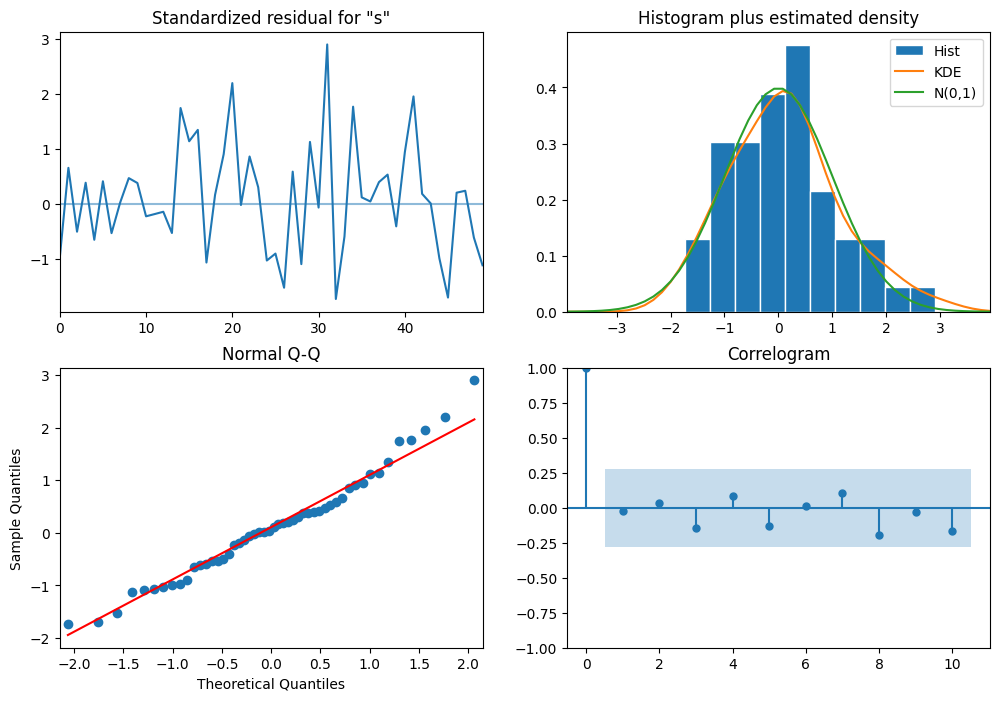

In [20]:
# Summarize the model results
print(arima_result.summary())

# Plot diagnostics
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

Looking at the Q-Q plot and density graphs, we see that the data satisfies the normal distribution assumption. This seems to be a decent model to predict the smoke estimates for the next 25 years.

Now using this model, lets predict the smoke estimates and also the uncertainity bounds for the predictions.

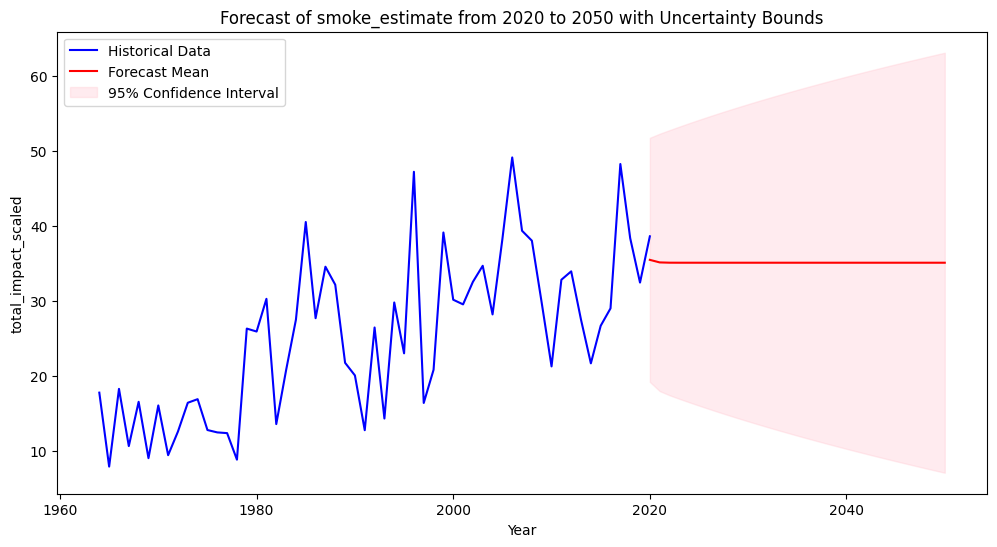

In [21]:
smoke_estimate_data = smoke_estimates_yearly["smoke_estimate"].to_pandas()

# Forecasting for 2020-2050 with ARIMA and calculating uncertainty bounds
forecast_years = range(2020, 2051)
n_forecasts = len(forecast_years)
forecast_result = ARIMA(smoke_estimate_data, order=(1, 1, 1)).fit()
forecast = forecast_result.get_forecast(steps=n_forecasts)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Plotting historical data and forecast with uncertainty bounds
plt.figure(figsize=(12, 6))
plt.plot(smoke_estimates_yearly['Fire_Year'], smoke_estimates_yearly['smoke_estimate'], label='Historical Data', color='blue')
plt.plot(forecast_years, forecast_mean, label='Forecast Mean', color='red')
plt.fill_between(forecast_years, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("Forecast of smoke_estimate from 2020 to 2050 with Uncertainty Bounds")
plt.xlabel("Year")
plt.ylabel("total_impact_scaled")
plt.legend()
plt.show()

In [22]:
forecasted_values = forecast_mean.to_frame()
forecasted_values["Year"] = forecast_years
forecasted_values.columns = ["Smoke Estimate", "Year"]
forecasted_values.to_csv("generated_files/intermediate/smoke_estimate_predictions_2020_2050_ARIMA.csv", index=False)
forecasted_values

,Smoke Estimate,Year
57,35.475050,2020
58,35.134058,2021
59,35.097030,2022
60,35.093009,2023
61,35.092573,2024
62,35.092525,2025
63,35.092520,2026
64,35.092520,2027
65,35.092520,2028
66,35.092520,2029


The above predictions for the years 2020 to 2050 indicate that there is not much change in the forecasted mean. This might be due to the fact that we are training a time series model on a relatively small dataset of 60 years. We notice that the confidence interval increases, which indicates that there is a 95% chance that the actual value will fall in the shaded region.

That being said, this implies that there is a scope of building a better predictive model. We might need to look into other options available like ARIMAX.

### Improving the predictive model

We saw that the above model's predicted smoke estimates did not change over the years. Lets try a SARIMAX model ability to capture seasonal variations and complex interactions between variables could lead to more dynamic and accurate forecasts of smoke estimates from wildfires. First, lets look at all the data we have related to wildfires

In [23]:
wildfires_enriched

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor,distance_factor,area_factor,smoke_estimate
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0,0.003988,255.61,0.268835
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0,0.013086,236.56,0.695231
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0,0.00305,138.63,0.058549
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0,0.005029,136.79,0.269626
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0,0.00455,129.95,0.232365
…,…,…,…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0,0.002206,3.81,0.002515
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0,0.002459,4.05,0.001767
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0,0.002226,2.66,0.002217


Since SARIMAX allows us to use external variables to capture complex patters, lets select a few fields which we believe deeply impact the smoke estimates. For the purpose of this project, I've decided to use the below fields as exogeneous(exog) variables - 
- GIS_Acres
- Shape_Area
- Circleness_Scale
- Closest_Distance_Miles

The variable we are trying to predict, i.e, smoke_estimate will be our endogeneous(endog) variable. 

Since the above data set has multiple wildfires per year, lets aggregate all the data to find yearly aggregates for all the endog and exog variables

In [30]:
wildfires_enriched_grouped = (wildfires_enriched
    .group_by("Fire_Year")
    .agg(
        pl.sum("smoke_estimate"),
        pl.sum("GIS_Acres"),
        pl.sum("Shape_Area"),
        pl.mean("Circleness_Scale"),
        pl.mean("Closest_Distance_Miles")
    )
    .sort("Fire_Year")
)
wildfires_enriched_grouped

Fire_Year,smoke_estimate,GIS_Acres,Shape_Area,Circleness_Scale,Closest_Distance_Miles
i64,f64,f64,f64,f64,f64
1964,17.757395,395304.329985,1.5997e9,0.53969,314.938673
1965,7.891844,137789.746877,5.5762e8,0.656606,299.523541
1966,18.259437,674338.939272,2.7290e9,0.611533,308.176207
1967,10.625853,323739.2263,1.3101e9,0.684848,257.167452
1968,16.536229,277628.703603,1.1235e9,0.621121,279.069471
…,…,…,…,…,…
2016,29.003212,2.1864e6,8.8479e9,0.38358,361.887336
2017,48.263021,4.6644e6,1.8876e10,0.389418,338.183023
2018,38.374925,4.8561e6,1.9652e10,0.395692,349.412481


Now that we have the aggregated data of all the endog and exog variables per year, we'll use this to train our SARIMAX model. Lets start by importing the required packages

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

Creating the following variables for ease of understanding - 

- training_data : Contains information of wildfires before the year 2015. Will be used as training data to check how well our model fits the existing data
- test_data : Contains information of wildfires in and after the year 2015. Will be used as test data to check how well our model fits the existing data
- endog_column : The endogeneous column of interest, i.e, the variable we want to predict
- exog_columns: The exogeneous columns of interest, i.e, the additional variables used for making the predictions

Some other fields are exog_train, exog_test, endog_train, endog_test are self explanatory

In [31]:
# Split data into train and test sets
training_data = wildfires_enriched_grouped.filter(pl.col("Fire_Year") < 2015)
test_data = wildfires_enriched_grouped.filter(pl.col("Fire_Year") >= 2015)

endog_column = ["smoke_estimate"]
exog_columns = ["GIS_Acres", "Shape_Area", "Circleness_Scale", "Closest_Distance_Miles" ]

# Prepare exogenous variables (assuming you have some)
# Replace 'exog_variable' with your actual exogenous variable name
exog_train = training_data[exog_columns].to_pandas()
endog_train = training_data[endog_column].to_pandas()
exog_test = test_data[exog_columns].to_pandas()
endog_test = test_data[endog_column].to_pandas()

# Try different ARIMAX orders
orders = [(1,1,1), (2,1,2), (1,1,2)]
results = {}

for order in orders:
   try:
       model = SARIMAX(endog_train, exog=exog_train, order=order).fit()
       pred = model.predict(start=len(endog_train),
                          end=len(endog_train) + len(endog_test) - 1,
                          exog=exog_test)
       mse = mean_squared_error(endog_test, pred)
       results[order] = mse
   except Exception as e:
       print(f"Error fitting model with order {order}: {e}")

print("\nMSE for different orders:", results)

# Use the best performing order for final model
best_order = min(results.items(), key=lambda x: x[1])[0]
print(f"\nBest performing order: {best_order}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03872D+00    |proj g|=  4.26512D+12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   4.265D+12   3.039D+00
  F =   3.0387163261537791     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

Now that we have a best performing order, lets use that and train the SARIMAX model using training data. Once the model is trained, lets observe some statistics that explain the model's performance on the data.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04434D+00    |proj g|=  3.62881D+12


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   3.629D+12   3.044D+00
  F =   3.0443360559054695     

ABNORMAL_TERMINATION_IN_LNSRCH                              
33.609475536216614
                               SARIMAX Results                                
Dep. Variable:         smoke_estimate   No. Observations:                   51
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -155.261
Date:                Sun, 24 Nov 2024   AIC                            328.522
Time:                        12:23:55   BIC                            345.730
Sample:  

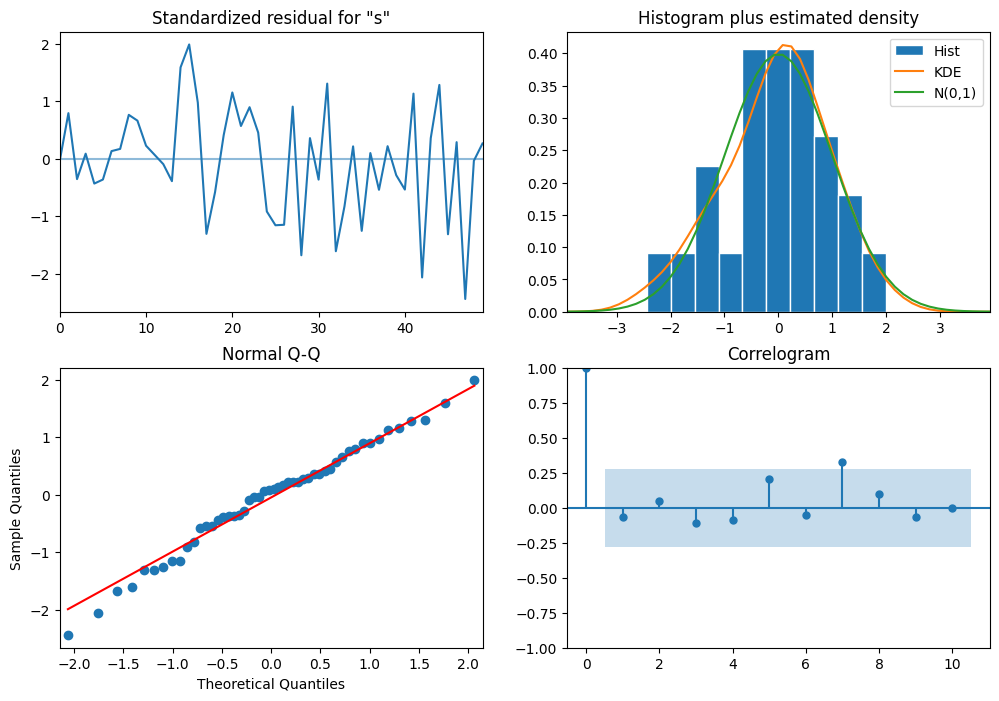

In [26]:
# ARIMAX Model
arimax_model = SARIMAX(endog_train, 
                       exog=exog_train,
                       order=best_order)
arimax_result = arimax_model.fit()
arimax_pred = arimax_result.forecast(steps=len(exog_test), exog=exog_test)
arimax_mse = mean_squared_error(endog_test, arimax_pred)
print(arimax_mse)

# Summarize the model results
print(arimax_result.summary())

# Plot diagnostics
arimax_result.plot_diagnostics(figsize=(12, 8))
plt.show()


Looking at the plots above, mainly QQ plots and Histogram plus estimated density, we learn that the model is well-fited with statistically significant parameters and residuals that meet the assumptions of normality and homoscedasticity.

This gives us confidence that this SARIMAX model might better predict the smoke estimates for the years 2020 to 2050. To get started, lets create a new SARIMAX model with the same endog and exog variables, but train it on all of the historic data

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04058D+00    |proj g|=  4.56401D+12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   4.564D+12   3.041D+00
  F =   3.0405778363465608     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                               SARIMAX Results                                
Dep. Variable:         smoke_estimate   No. Observations:                   57
Model:               SARIMAX(2, 1, 2

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


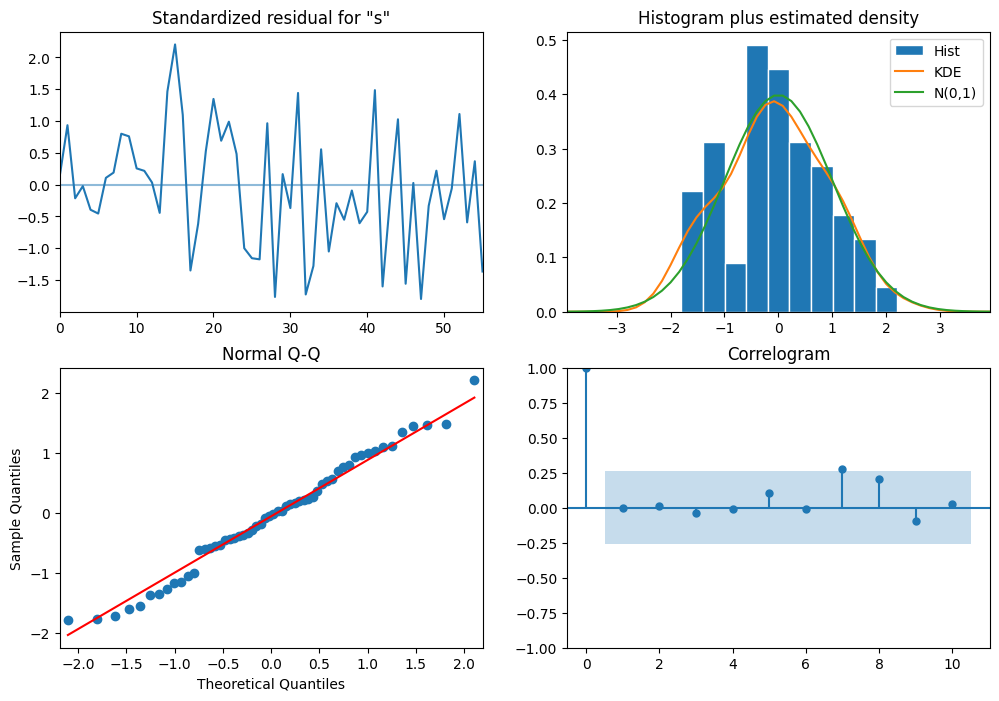

In [27]:
# Create dataframes containing data for all endog and exog variables
endog = wildfires_enriched_grouped[endog_column].to_pandas()
exog = wildfires_enriched_grouped[exog_columns].to_pandas()

smoke_estimate_prediction_model = SARIMAX(endog=endog, 
                          exog=exog,
                          order=best_order).fit()


# Summarize the model results
print(smoke_estimate_prediction_model.summary())

# Plot diagnostics
smoke_estimate_prediction_model.plot_diagnostics(figsize=(12, 8))
plt.show()

We see that this model trained on all of the historic data also has residuals meeting the assumptions of normality and homoscedasticity. Lets now use this model to forecast smoke_estimates for the years 2020-2050. Since we do not have any data about the exogenous variables for the years 2020-2050, we'll estimate the future values for each exog variable and then feed them into the model to predict smoke_estimates

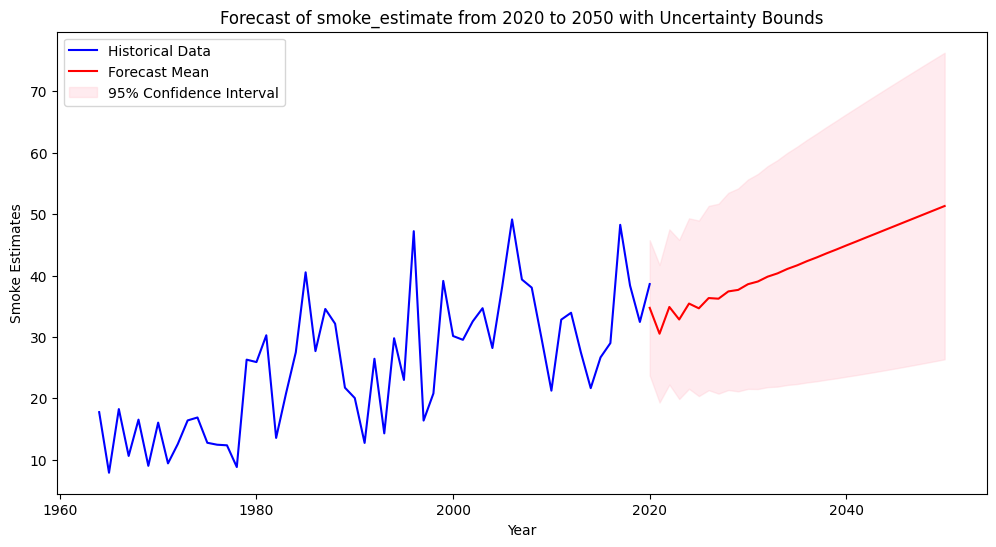

In [32]:
# Forecasting for 2020-2050 with ARIMAX and calculating uncertainty bounds
forecast_years = range(2020, 2051)
future_data = pd.DataFrame(index=forecast_years)

# Prepare exogenous variables for forecasting
for col in exog.columns:
      z = np.polyfit(wildfires_enriched_grouped['Fire_Year'], exog[col], 1)
      p = np.poly1d(z)
      future_data[col] = p(future_data.index)

forecast = smoke_estimate_prediction_model.get_forecast(steps=len(future_data), exog=future_data)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Plotting historical data and forecast with uncertainty bounds
plt.figure(figsize=(12, 6))
plt.plot(wildfires_enriched_grouped['Fire_Year'], wildfires_enriched_grouped['smoke_estimate'], label='Historical Data', color='blue')
plt.plot(forecast_years, forecast_mean, label='Forecast Mean', color='red')
plt.fill_between(forecast_years, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("Forecast of smoke_estimate from 2020 to 2050 with Uncertainty Bounds")
plt.xlabel("Year")
plt.ylabel("Smoke Estimates")
plt.legend()
plt.show()

Looking at the forecasted smoke_estimates, this model seems to be better performing than our previous ARIMA model. Lets store the predicted values in a file for use in Part-2 of this project

In [29]:
sarimax_forecasted_values = forecast_mean.to_frame()
sarimax_forecasted_values["Year"] = forecast_years
sarimax_forecasted_values.columns = ["Smoke Estimate", "Year"]
sarimax_forecasted_values.to_csv("generated_files/intermediate/smoke_estimate_predictions_2020_2050_SARIMAX.csv", index=False)
sarimax_forecasted_values

,Smoke Estimate,Year
57,34.741613,2020
58,30.528380,2021
59,34.885178,2022
60,32.846980,2023
61,35.439628,2024
62,34.665104,2025
63,36.337519,2026
64,36.231593,2027
65,37.418083,2028
66,37.665303,2029
